# Introduction to TensorFlow

> Prerequisites for Building Models with TensorFlow

郭耀仁

## 大綱

- 機器學習基礎
- Loss Functions
- 梯度遞減
- Name Scopes
- Optimizers
- Summaries for TensorBoard
- Lazy Loading

## 機器學習基礎

## 常見入門途徑有兩種

- 從理論入門
- 從工具（Scikit-Learn、TensorFlow、PyTorch...等）入門

## 從理論入門

- [Andrew Ng: Machine Learning](https://www.coursera.org/learn/machine-learning)
- [林軒田：機器學習基石](https://www.coursera.org/learn/ntumlone-mathematicalfoundations/)
- [Deep Learning](https://www.deeplearningbook.org/)
- [Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)

## 從工具入門

- [Scikit-Learn](https://scikit-learn.org/stable/)
- [Google Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/ml-intro)
- [fast.ai](https://www.fast.ai/)

## Scikit-Learn 是學習門檻較低的選項

## 先關注 Scikit-Learn 的這三個模組

- Preprocessing
- Supervised Learning
    - Classification
    - Regression
- Model Selection

## 暸解資料的長相

- Feature Matrix: 常用 X 代表
- Target Vector: 常用 y 代表

## 通常我們讀入的資料整合 X 與 y

- 讀入資料外觀 `(m, n+1)`：m 個觀測值、n+1 個特徵
    - y：`(m, 1)`
    - X：`(m, n)`

![](img/0401.png)

## Loss Functions

## 有時也被稱為成本函數（Cost Functions）

- 每個學習模型在訓練過程的目標都相同：**想辦法找到一組讓 Loss Function 最小化的係數**（Minimize the loss function!）
    - 線性迴歸：讓 MSE 最低
    - 羅吉斯迴歸：讓誤分類數最低
    - 決策樹：讓 cross-entropy 最低
    - ...etc.

## Loss Functions 是 TensorFlow 框架中的基礎

- 模型訓練的依據
- 模型好壞的判定

## `tf.keras` 有許多內建的 Loss Functions

- `tf.keras.losses.mse()`
- `tf.keras.losses.mae()`
- `tf.keras.losses.Huber()`

## 不同的 Loss Functions 背後的用意是什麼

- 如何懲罰資料中的 outliers
- 假如不希望 outliers 對模型的影響很大：使用 MAE / Huber error

![](img/loss_functions.png)

## 一個簡單的 Loss Function: MSE

In [1]:
import numpy as np
import tensorflow as tf

y = np.arange(100, dtype=float)
y_pred = np.full((100,), 10, dtype=float)
mse = ((y-y_pred)**2).sum() / y.size
print(mse)

2393.5


## 隨堂練習

使用 `tf.kereas.losses.mse()` 算算看？

In [2]:
import numpy as np
import tensorflow as tf

y = np.arange(100, dtype=float)
y_pred = np.full((100,), 10, dtype=float)
loss = tf.keras.losses.mse(y, y_pred)
with tf.Session() as sess:
    print(sess.run(loss))

2393.5


## 用 Kaggle 資料試試看

In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

train_url = "https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv"
train_df = pd.read_csv(train_url)
X = train_df["GrLivArea"].values.reshape(-1, 1)
y = train_df["SalePrice"].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test.ravel(), y_pred.ravel())
print(mse)

2541490406.316298


## 隨堂練習

使用 `tf.kereas.losses.mse()` 算算看？

In [4]:
import tensorflow as tf

loss = tf.keras.losses.mse(y_test.ravel(), y_pred.ravel())
with tf.Session() as sess:
    print(sess.run(loss))

2541490406.3162975


## 隨堂練習

使用 `tf.kereas.losses.mae()` 算算看？

In [5]:
import tensorflow as tf

loss = tf.keras.losses.mae(y_test.ravel(), y_pred.ravel())
with tf.Session() as sess:
    print(sess.run(loss))

34616.84747058942


## 相同的 $y_{pred}$ 為何 MSE 會比 MAE 大這麼多？

## 梯度遞減

## 定義好 Loss Function 以後呢？

是找出真實、能讓 Loss Function 為 0 的 $f(x)$ 函數嗎？

$$f(x)$$

## 定義好 Loss Function 以後

其實是找出能夠讓 Loss Function 很小、長得跟 $f(x)$ 函數很像很像的 $h(x)$ 函數！

$$h(x) = X\theta$$

## 那又該如何著手？

> 千里之行，始於足下。

## 但是要有技巧地往對的方向移動

![](img/0402.png)

## 計算 Loss Function 的斜率（梯度）

$$
L = \frac{1}{m}\sum_{i=0}^n(y_i - \hat{y_i})^2 = \frac{1}{m}\sum_{i=0}^m(y_i - (ax_i + b))^2 \\
$$

General Form:

$$
\Delta W = \frac{\partial L}{\partial W}
$$

## 找到正確的方向，然後用適當的速度前進

$$
a := a - \alpha \frac{\partial L}{\partial a} \\
\frac{\partial L}{\partial a} = \frac{-2}{m}\sum_{i=0}^m x_i(y_i - (ax_i+b)) = \frac{-2}{m}\sum_{i=0}^m x_i(y_i - \hat{y_i}) \\
b := b - \alpha \frac{\partial L}{\partial b} \\
\frac{\partial L}{\partial b} = \frac{-2}{m}\sum_{i=0}^m (y_i - \hat{y_i})
$$

General Form:

$$
W := W - \alpha \Delta W \\
W := W - \alpha \frac{1}{m}(X^T(X\theta - y))
$$

In [6]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(1, 30, 30)
y = 2*x + 3

## 給定 $x$ 與 $y$

In [7]:
print(x)
print(y)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
[ 5.  7.  9. 11. 13. 15. 17. 19. 21. 23. 25. 27. 29. 31. 33. 35. 37. 39.
 41. 43. 45. 47. 49. 51. 53. 55. 57. 59. 61. 63.]


## 我們如何得知 $y$ 與 $x$ 的關係，求 $a$ 和 $b$

$$y = ax + b$$

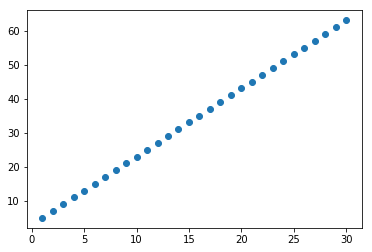

In [8]:
plt.scatter(x, y)
plt.show()

In [9]:
import numpy as np

def grad_descent(x, y, alpha=0.001, n_epochs=100000):
    a = 1
    b = 1
    m = y.size
    loss_history = np.zeros(n_epochs)
    for n_epoch in range(n_epochs):
        y_pred = a*x + b
        d_a = (-2/m) * (x * (y - y_pred)).sum()
        d_b = (-2/m) * (y - y_pred).sum()
        a = a - alpha * d_a
        b = b - alpha * d_b
    return a, b

grad_descent(x, y)

(2.0000000000000244, 2.999999999999512)

## Name Scopes

## 一個 TensorFlow 計算圖形（Graph）中會有
    
- 變數張量
- Placeholder 張量
- 運算節點

## 當模型變得複雜，TensorBoard 就會顯得凌亂
    
- 使用 `tf.name_scope()` 來解決
- 會在每個張量的命名前面加入 Name Space 的名稱

In [10]:
import tensorflow as tf

with tf.name_scope("constants"):
  lucky_number_const = tf.constant(24)
  stupid_number_const = tf.constant(87)

with tf.name_scope("variables"):
  lucky_number_var = tf.Variable(24)
  stupid_number_var = tf.Variable(87)

with tf.name_scope("placeholders"):
  X = tf.placeholder(tf.float32, (5, 1))
  y = tf.placeholder(tf.float32, (5,))

print(lucky_number_const)
print(stupid_number_const)
print(lucky_number_var)
print(stupid_number_var)
print(X)
print(y)

Instructions for updating:
Colocations handled automatically by placer.
Tensor("constants/Const:0", shape=(), dtype=int32)
Tensor("constants/Const_1:0", shape=(), dtype=int32)
<tf.Variable 'variables/Variable:0' shape=() dtype=int32_ref>
<tf.Variable 'variables/Variable_1:0' shape=() dtype=int32_ref>
Tensor("placeholders/Placeholder:0", shape=(5, 1), dtype=float32)
Tensor("placeholders/Placeholder_1:0", shape=(5,), dtype=float32)


## Optimizers

## 到目前訓練模型還缺什麼？

- Placeholders: 餵入資料點
- Loss functions
- 梯度遞減

## 我們不知道該怎麼樣讓 TensorFlow 開始做梯度遞減

## 透過 `tf.train.XXX()` 啟動

- `tf.train.GradientDescentOptimizer()`
- `tf.train.AdamOptimizer()`
- ...etc.

```python
# pseudo code
learning_rate = .001
with tf.name_scope("optimizer"):
  train_op = tf.train.AdamOptimizer(learning_rate).minimize(l) # l as in some loss function
```

## Summaries for TensorBoard

## 先前我們僅使用 graph 頁籤

- Graph 頁籤：觀察計算圖
- Scalar 頁籤：觀察 loss function 是否隨著訓練次數增加而遞減

## 以 `tf.summary` 將 Scalar 與 Graph 整合至 TensorBoard

```python
with tf.name_scope("summaries"):
  tf.summary.scalar("loss", l)
  merged = tf.summary.merge_all()

train_writer = tf.summary.FileWriter('/graphs/tmp', tf.get_default_graph())
```

## Lazy Loading

## 何謂 Lazy Loading

- Normal Loading: 在執行 Session 之前將運算（節點）定義完畢
- Lazy Loading: 在 Session 中將運算（節點）輸入

In [11]:
tf.reset_default_graph()

In [12]:
# Normal Loading
x = tf.Variable(10, name='x')
y = tf.Variable(20, name='y')
z = tf.add(x, y) # check point!

writer = tf.summary.FileWriter('./graphs/normal_loading', tf.get_default_graph())
with tf.Session() as sess:
  sess.run(x.initializer)
  sess.run(y.initializer)
  for _ in range(10):
    sess.run(z)
writer.close()

In [13]:
tf.get_default_graph().as_graph_def()

node {
  name: "x/initial_value"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 10
      }
    }
  }
}
node {
  name: "x"
  op: "VariableV2"
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: ""
    }
  }
}
node {
  name: "x/Assign"
  op: "Assign"
  input: "x"
  input: "x/initial_value"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@x"
      }
    }
  }
  attr {
    key: "use_locking"
    value {
      b: true
    }
  }
  attr {
    key: "validate_shape"
    value {
      b: true
    }
  }
}
node {
  name: "x/read"
  op: "Identity"
  input

In [14]:
tf.reset_default_graph()

In [15]:
# Lazy Loading
x = tf.Variable(10, name='x')
y = tf.Variable(20, name='y')

writer = tf.summary.FileWriter('./graphs/lazy_loading', tf.get_default_graph())
with tf.Session() as sess:
  sess.run(x.initializer)
  sess.run(y.initializer)
  for _ in range(10):
    sess.run(tf.add(x, y)) # check point!
writer.close()

In [16]:
tf.get_default_graph().as_graph_def()

node {
  name: "x/initial_value"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 10
      }
    }
  }
}
node {
  name: "x"
  op: "VariableV2"
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: ""
    }
  }
}
node {
  name: "x/Assign"
  op: "Assign"
  input: "x"
  input: "x/initial_value"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@x"
      }
    }
  }
  attr {
    key: "use_locking"
    value {
      b: true
    }
  }
  attr {
    key: "validate_shape"
    value {
      b: true
    }
  }
}
node {
  name: "x/read"
  op: "Identity"
  input